In [1]:
using ITensors
using LinearAlgebra
using LaTeXStrings
using Plots
using ProgressMeter
using Statistics
using StatsBase

global const nsweeps::Int = 100
global const maxdim::Int = 10000
global const cutoff::Float64 = 1e-12
global const noise::Vector{Float64} = [1e-5, 1e-6, 0.0]

global const observer::DMRGObserver{Float64} = DMRGObserver(energy_tol=1e-6)

global const rho::Float64 = (sqrt(5) - 1) / 2  # 1 / phi
global const rho2::Float64 = (3 - sqrt(5)) / 2;  # 1 / phi^2

ITensors.Strided.disable_threads()
ITensors.Strided.disable_threaded_mul()

ITensors.enable_combine_contract()
ITensors.enable_contraction_sequence_optimization()

In [2]:
function build_HAos(ns::Int, A=20)
    N = 4 + 3*(ns - 1)
    
    os = OpSum()
    
    os += 2, "Z", 1, "Z", ns+1
    os += 2, "Z", N, "Z", 2*ns+1
    
    # source horizontal edge
    os += -1, "Z", 1, "Z", 2
    os += -1, "Z", 1, "Z", ns+2
    os += -2, "Z", 1
    # target horizontal edge
    os += -1, "Z", N, "Z", 2*ns
    os += -1, "Z", N, "Z", N-1
    os += -2, "Z", N

    # horizontal right edge
    os += +1, "Z", ns, "Z", 2*ns
    os += -1, "Z", ns, "Z", ns-1
    os += -1, "Z", ns, "Z", 2*ns+1
    os += +2, "Z", ns
    # horizontal left edge
    os += +1, "Z", 2*ns+2, "Z", ns+2
    os += -1, "Z", 2*ns+2, "Z", 2*ns+3
    os += -1, "Z", 2*ns+2, "Z", ns+1
    os += +2, "Z", 2*ns+2

    # vertical corner edges
    os += -1, "Z", ns+1, "Z", 2*ns+2
    os += -1, "Z", 2*ns+1, "Z", ns

    # lower horizontal internal edges
    for i in 2:ns-1
        os += +1, "Z", i, "Z", i+ns
        os += -1, "Z", i, "Z", i-1
        os += -1, "Z", i, "Z", i+ns+1
        os += -1, "Z", i, "Z", i+1
    end

    # vertical internal edges
    for i in ns+2:2*ns
        os += +1, "Z", i, "Z", i-ns
        os += +1, "Z", i, "Z", i+ns
        os += -1, "Z", i, "Z", i-ns-1
        os += -1, "Z", i, "Z", i+ns+1
        os += +4, "Z", i
    end

    # higher horizontal internal edges
    for i in 2*ns+3:N-1
        os += +1, "Z", i, "Z", i-ns
        os += -1, "Z", i, "Z", i-1
        os += -1, "Z", i, "Z", i-ns-1
        os += -1, "Z", i, "Z", i+1
    end
    
    os *= A / 4
    
    J = zeros(N, N)
    K = zeros(N)
    
    J[1, ns+1] += 2
    J[2*ns+1, N] += 2
    
    # source and tagert horizontal edges
    J[1, 2] += -1
    J[1, ns+2] += -1
    K[1] += -2
    
    J[2*ns, N] += -1
    J[N-1, N] += -1
    K[N] += -2

    # horizontal corner edges
    J[ns, 2*ns] += 1
    J[ns-1, ns] += -1
    J[ns, 2*ns+1] += -1
    K[ns] += 2
    
    J[ns+2, 2*ns+2] += 1
    J[2*ns+2, 2*ns+3] += -1
    J[ns+1, 2*ns+2] += -1
    K[2*ns+2] += 2
    
    # vertical corner edges    
    J[ns+1, 2*ns+2] += -1
    J[ns, 2*ns+1] += -1
    
    # lower horizontal internal edges
    for i in 2:ns-1
        J[i, i+ns] += 1
        J[i-1, i] += -1
        J[i, i+ns+1] += -1
        J[i, i+1] += -1
    end
    # vertical internal edges
    for i in ns+2:2*ns
        J[i-ns, i] += 1
        J[i, i+ns] += 1
        J[i-ns-1, i] += -1
        J[i, i+ns+1] += -1
        K[i] += 4
    end
    # higher horizontal internal edges
    for i in 2*ns+3:N-1
        J[i-ns, i] += 1
        J[i-1, i] += -1
        J[i-1-ns, i] += -1
        J[i, i+1] += -1
    end
    
    K = A/4 * K
    J = A/4 * J
    J = J .+ transpose(J)

    os = OpSum()
    for i in 1:N
        for j in i+1:N
            if J[i, j] != 0
                os .+= J[i, j], "Z", opt_i(i, ns), "Z", opt_i(j, ns)
            end
        end
    end
    
    for i in 1:N
        if K[i] != 0
            os .+= K[i], "Z", opt_i(i, ns)
        end
    end

    return os, J
end


function build_HBos(ns::Int, W, B=1)
    N = 4 + 3*(ns - 1)

    os = OpSum()
    for j in 1:N
        os += B/2*W[j], "Z", opt_i(j, ns)
    end

    return os
end


function build_Hxos(ns::Int)
    N = 4 + 3*(ns - 1)
    
    os = OpSum()
    for j in 1:N
        os += -1, "X", j
    end

    return os
end;

In [3]:
function opt_i(i::Int, ns::Int)
    if i <= ns
        return 3*i - 1
    elseif i < (2*ns + 2)
        return 3*(i-ns-1) + 1
    else
        return 3*(i-(2*ns + 1))
    end
end

opt_i (generic function with 1 method)

In [4]:
function compute_delta(sites::Vector{Index{Int64}}, N::Int, s::Float64, HA::MPO, HB::MPO, Hx::MPO; 
                       psi0_init=MPS()::MPS, psi1_init=MPS()::MPS)
    H = (1-s)*Hx + s*(HA + HB)
    
    if psi0_init.rlim == 0
        state = StatsBase.sample(["Up", "Dn"], N)
        psi0_init = MPS(sites, state)
    end
    
    # [(1-s)*Hx, s*HA, s*HB]
    E0, psi0 = dmrg(H, psi0_init; nsweeps=nsweeps, maxdim=maxdim, cutoff=cutoff, 
                    noise=noise, eigsolve_krylovdim=10, outputlevel=0, observer=observer)
    
    if psi1_init.rlim == 0
        state = StatsBase.sample(["Up", "Dn"], N)
        psi1_init = MPS(sites, state)

    else
        
    end
    
    E1, psi1 = dmrg(H, [psi0], psi1_init; nsweeps=nsweeps, maxdim=maxdim, cutoff=cutoff,
                    noise=noise, eigsolve_krylovdim=10, outputlevel=0, observer=observer, weight=2)

    if E1 > E0
        return E1-E0, psi0, psi1
    else
        return E0-E1, psi1, psi0
    end
end


function find_delta_min(sites::Vector{Index{Int64}}, N::Int, V::Matrix{Float64}, HA::MPO, HB::MPO, 
                        Hx::MPO, psi0_f::MPS, psi1_f::MPS; tol=1e-3::Float64)

    a = 2 / (N+2)
    b = min(1, 2/sqrt(N/2))

    h = b - a
    c = a + rho2 * h
    d = a + rho * h

    # Required steps to achieve tolerance
    n = trunc(Int, ceil(log(tol / h) / log(rho)))
    
    yd, psi0d, psi1d = compute_delta(sites, N, d, HA, HB, Hx, psi0_init=deepcopy(psi0_f), psi1_init=deepcopy(psi1_f))
    yc, psi0c, psi1c = compute_delta(sites, N, c, HA, HB, Hx, psi0_init=deepcopy(psi0d), psi1_init=deepcopy(psi1d))
    
    for k in 1:n
        if yc < yd
            b = d
            d = c
            yd = yc
            h = rho * h
            c = a + rho2 * h

            yc, psi0c, psi1c = compute_delta(sites, N, c, HA, HB, Hx, psi0_init=psi0c, psi1_init=psi1c)
        else
            a = c
            c = d
            yc = yd
            h = rho * h
            d = a + rho * h

            yd, psi0d, psi1d = compute_delta(sites, N, d, HA, HB, Hx, psi0_init=psi0d, psi1_init=psi1d)
        end
    end
    
    if yc < yd
        sc = (a + d) / 2
        psi0 = deepcopy(psi0d)
        psi1 = deepcopy(psi1d)
    else
        sc = (b + c) / 2
        psi0 = deepcopy(psi0c)       
        psi1 = deepcopy(psi1c)
    end
    
    dmin, psi0, psi1 = compute_delta(sites, N, sc, HA, HB, Hx, psi0_init=psi0, psi1_init=psi1)
    
    return sc, dmin, psi0
end;

In [5]:
using PyCall

py"""
from itertools import islice

import networkx as nx

def two_sp(ns, W):
    G = nx.grid_2d_graph(2, ns+1)
    G = nx.DiGraph(G)
    for edge in G.copy().edges():
        if edge != tuple(sorted(edge)):
            G.remove_edge(*edge)

    source = (0, 0)
    target = (1, ns)

    edges = []
    for i in range(ns):
        edges.append(((0, i), (0, i+1)))
    for i in range(ns+1):
        edges.append(((0, i), (1, i)))
    for i in range(ns):
        edges.append(((1, i), (1, i+1)))
    
    for i, e in enumerate(edges):
        G[e[0]][e[1]]['weight'] = W[i]

    p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))

    return p0, p1, edges
"""

In [6]:
A = 4
B = 1

os_HA1 = OpSum()

os_HA1 +=  1, "Z", 1, "Z", 2
os_HA1 +=  1, "Z", 3, "Z", 4
os_HA1 += -1, "Z", 1, "Z", 3
os_HA1 += -1, "Z", 2, "Z", 4
os_HA1 *= A/2;

J1 = zeros(4, 4)
J1[1, 2] = 1
J1[3, 4] = 1
J1[1, 3] = -1
J1[2, 4] = -1
J1 *= A/2
J1 = J1 .+ transpose(J1);

In [7]:
ns = 2

N = 4 + 3*(ns - 1)

B = 1
A = B*N
sites = siteinds("S=1/2", N)

if ns != 1
    os_HA, J = build_HAos(ns, A)
else
    os_HA = copy(os_HA1)
    J = copy(J1)
end
HA = MPO(os_HA, sites)

os_Hx = build_Hxos(ns)
Hx = MPO(os_Hx, sites)

e, V = eigen(J)

W = rand(N)

# W = randn(N) ./ 7 .+ 0.5
# W[W .> 1] .= 1
# W[W .< 0] .= 0

os_HB = build_HBos(ns, W, B)
HB = MPO(os_HB, sites);

In [8]:
p0, p1, edges = py"two_sp"(ns, W)

p0 = [(p0[i], p0[i+1]) for i in 1:(length(p0)-1)]
p1 = [(p1[i], p1[i+1]) for i in 1:(length(p1)-1)]
p0 = indexin(p0, edges)
p1 = indexin(p1, edges)

p0 = [opt_i(e, ns) for e in p0]
p1 = [opt_i(e, ns) for e in p1]
dh = sum(abs.([n in p0 ? 1 : 0 for n in 1:N] .- [n in p1 ? 1 : 0 for n in 1:N]))

psi0_f = MPS(sites, [n in p0 ? "Up" : "Dn" for n in 1:N])
psi1_f = MPS(sites, [n in p1 ? "Up" : "Dn" for n in 1:N])

Hp = HA + HB
df = inner(psi1_f', Hp, psi1_f) - inner(psi0_f', Hp, psi0_f)

df, dh

(0.2574008429888792, 4)

In [9]:
@time sc, dmin, psi_sc = find_delta_min(sites, N, V, HA, HB, Hx, psi0_f, psi1_f)
sc, dmin, inner(psi0_f, psi_sc)^2

  9.208688 seconds (31.38 M allocations: 3.223 GiB, 6.96% gc time, 87.89% compilation time)


(0.35886335581484996, 0.09751835286867738, 0.8131878971220737)

In [10]:
M = 500
dE = zeros(M)
overlap0 = zeros(M)
overlap1 = zeros(M)
dH_ds = zeros(M)

S = LinRange(0., 1, M+1)
S = S .+ S[2]
S = S[1:end-1]

psi0 = deepcopy(psi0_f)
psi1 = deepcopy(psi1_f)

time = zeros(M)
@showprogress for (i, s) in Iterators.reverse(enumerate(S))
    time[i] = @elapsed dE[i], psi0, psi1 = compute_delta(sites, N, s, HA, HB, Hx, 
                                                         psi0_init=psi0, psi1_init=psi1)

    overlap0[i] = inner(psi0_f, psi0)^2
    overlap1[i] = inner(psi1_f, psi0)^2
    dH_ds[i] = abs(inner(psi1', Hp-Hx, psi0))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


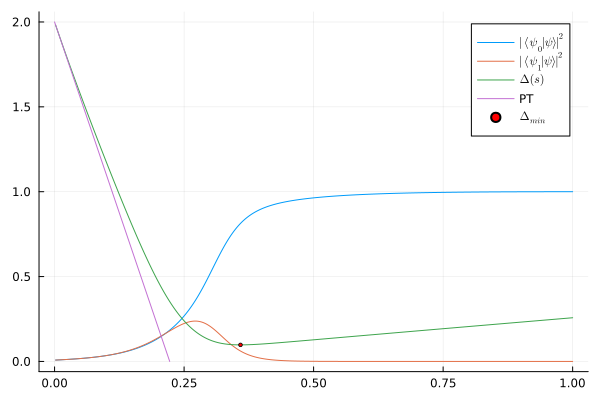

In [11]:
plot(S, [overlap0, overlap1, dE],
     label=[L"| \langle \psi_0 | \psi \rangle |^2" L"| \langle \psi_1 | \psi \rangle |^2" L"\Delta (s)"])

plot!(LinRange(0., 2/(N+2), 100), LinRange(0., 2/(N+2), 100) .* -(N+2) .+2, label="PT")
# plot!(S, S*df, label="PT")

# plot!([S[argmin(dE)]], [minimum(dE)], seriestype=:scatter, label=L"\Delta_{min}", 
#       marker=:vline, markersize=10, markerstrokewidth=1, color=:green)

plot!([sc], [dmin], seriestype=:scatter, label=L"\Delta_{min}", markersize=2, color=:red)